# Car Price Prediction Problem Description

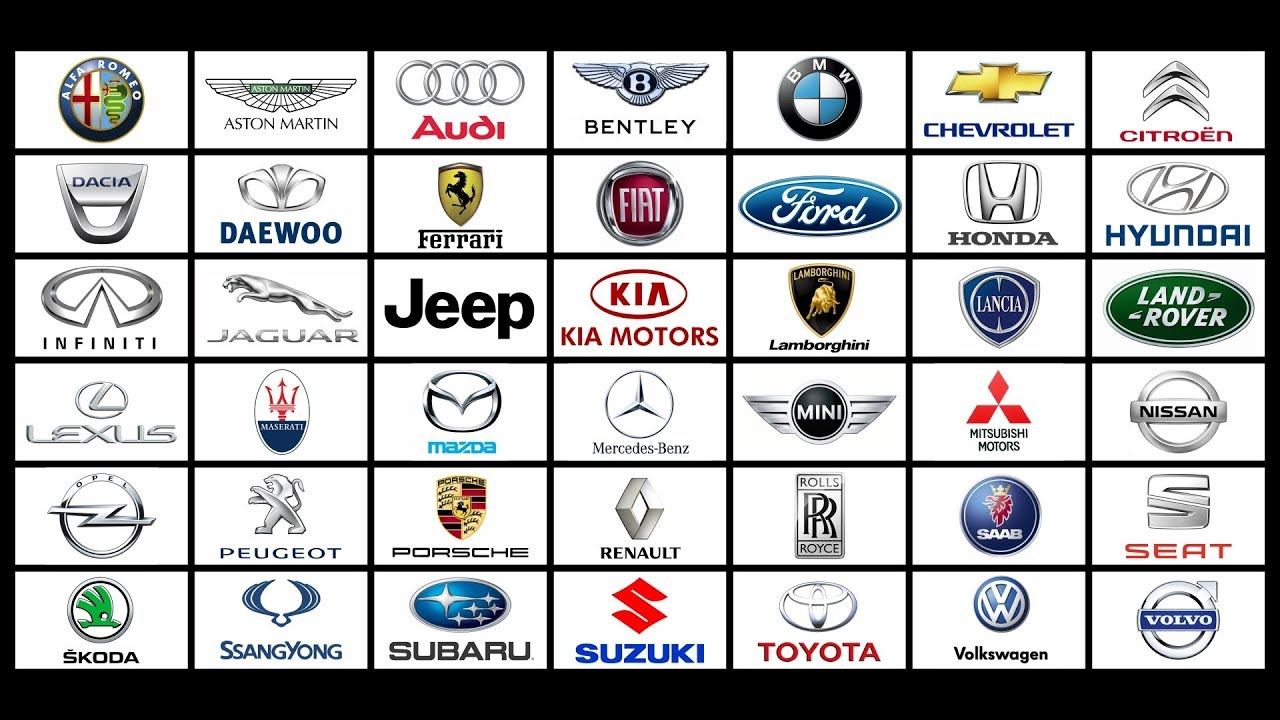

A new automobile company aspires to enter the cars market by setting up their manufacturing unit and producing cars locally to give competition to other Cars companies.
They have contracted an automobile consulting company to understand the factors on which the pricing of cars depends. Specifically, they want to understand the factors affecting the pricing of cars in the American market, since those may be very different from the Chinese market. Essentially, the company wants to know:
>- Which variables are significant in predicting the price of a car
>- How well those variables describe the price of a car

Based on various market surveys, the consulting firm has gathered a large dataset of different types of cars across the American market.

# Business Goal
You are required to model the price of cars with the available independent variables. It will be used by the management to understand how exactly the prices vary with the independent variables. They can accordingly manipulate the design of the cars, the business strategy etc. to meet certain price levels. Further, the model will be a good way for the management to understand the pricing dynamics of a new market.

# Data Preparation
There is a variable named CarName which is comprised of two parts: the first word is the name of 'car company' and the second is the 'car model'. For example, chevrolet impala has 'chevrolet' as the car company name and 'impala' as the car model name. You need to consider only company name as the independent variable for model building.


The solution is divided into the following sections: 
1. Data understanding and exploration
2. Data cleaning
3. Data preparation
4. Model building and evaluation

# 1. Data understanding and exploration

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set_style("whitegrid")

pd.set_option("display.max_columns", 80)
pd.set_option("display.max_rows", 80)
pd.set_option("display.float", "{:.2f}".format)

In [ ]:
data = pd.read_csv('/kaggle/input/automobile-consulting-company/CarPrice_Assignment.csv')
data.head()

In [ ]:
data.info()

In [ ]:
data.describe()

In [ ]:
for column in data.columns:
    print(f"{column}: {data[column].nunique()}")
    if data[column].nunique() < 10:
        print(f"{data[column].value_counts()}")
    print("====================================")

## **`car_ID`**

In [ ]:
data.car_ID.nunique()

In [ ]:
data.set_index('car_ID', inplace=True)
data.index.name = None
data.head()

## `price`

In [ ]:
sns.distplot(data.price, bins=30)

## Discrete Features

In [ ]:
discrete_col = ['fueltype', 'fuelsystem', 'aspiration', 'doornumber', 'carbody', 
                'drivewheel', 'enginelocation', 'enginetype', 'symboling', 
                'cylindernumber']
plt.figure(figsize=(15, 15))
for i, column in enumerate(discrete_col, 1):
    plt.subplot(4, 3, i)
    sns.scatterplot(column, 'price', data=data, hue='price')

## Continuous Features

In [ ]:
continous_col = ['wheelbase', 'carlength', 'carwidth', 'carheight', 
                 'curbweight', 'enginesize', 'boreratio', 'stroke', 
                 'horsepower', 'peakrpm', 'citympg', 'highwaympg', 
                 'compressionratio']
plt.figure(figsize=(15, 15))
for i, column in enumerate(continous_col, 1):
    plt.subplot(4, 4, i)
    sns.scatterplot(column, 'price', data=data, hue='price')

In [ ]:
continous_col = ['wheelbase', 'carlength', 'carwidth', 'carheight', 
                 'curbweight', 'enginesize', 'boreratio', 'stroke', 
                 'horsepower', 'peakrpm', 'citympg', 'highwaympg', 
                 'compressionratio']
plt.figure(figsize=(15, 15))
for i, column in enumerate(continous_col, 1):
    plt.subplot(4, 4, i)
    sns.distplot(data[column])

## Correlation Analysis

In [ ]:
plt.figure(figsize=(12, 10))
sns.heatmap(data.corr(), annot=True)

The heatmap shows some useful insights:

Correlation of price with independent variables:
- Price is highly (positively) correlated with wheelbase, carlength, carwidth, curbweight, enginesize, horsepower (notice how all of these variables represent the size/weight/engine power of the car)

- Price is negatively correlated to ```citympg``` and ```highwaympg``` (-0.70 approximately). This suggest that cars having high mileage may fall in the 'economy' cars category, and are priced lower (think Maruti Alto/Swift type of cars, which are designed to be affordable by the middle class, who value mileage more than horsepower/size of car etc.)

Correlation among independent variables:
- Many independent variables are highly correlated (look at the top-left part of matrix): wheelbase, carlength, curbweight, enginesize etc. are all measures of 'size/weight', and are positively correlated 


Thus, while building the model, we'll have to pay attention to multicollinearity (especially linear models, such as linear and logistic regression, suffer more from multicollinearity).

# 2. Data Cleaning

## `CarName`

In [ ]:
data.CarName.nunique()

In [ ]:
data['brand'] = data.CarName.str.split(' ', expand=True)[0].str.lower()

data['brand'] = data.brand.str.replace('toyouta', 'toyota')
data['brand'] = data.brand.str.replace('porcshce', 'porsche')
data['brand'] = data.brand.str.replace('maxda', 'mazda')
data['brand'] = data.brand.str.replace('vw', 'volkswagen').str.replace('vokswagen', 'volkswagen')
data['brand'] = data.brand.str.replace('vw', 'volkswagen').str.replace('vokswagen', 'volkswagen')

data.brand.value_counts()

In [ ]:
plt.figure(figsize=(8, 5))
sns.scatterplot('brand', 'price', data=data, hue='price')

In [ ]:
data.brand.nunique()

In [ ]:
data.drop('CarName', axis=1, inplace=True)

# 3. Data Pre-processing

In [ ]:
object_features = data.select_dtypes(include=('object')).columns.tolist()
object_features

In [ ]:
data_1 = pd.get_dummies(data, columns=object_features, drop_first=True, dtype='uint8')

In [ ]:
data_1.dtypes

In [ ]:
data_1.info()

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X = data_1.drop('price', axis=1)
y = data_1.price

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

In [ ]:
from sklearn import metrics

def print_evaluate(true, predicted, train=True):  
    mae = metrics.mean_absolute_error(true, predicted)
    mse = metrics.mean_squared_error(true, predicted)
    rmse = np.sqrt(metrics.mean_squared_error(true, predicted))
    r2_square = metrics.r2_score(true, predicted)
    if train:
        print("========Training Result=======")
        print(f'MAE:\t\t {mae:.4f}')
        print(f'MSE:\t\t {mse:.4f}')
        print(f'RMSE:\t\t {rmse:.4f}')
        print(f'R2 Square:\t {r2_square:.4f}')
    elif not train:
        print("=========Testing Result=======")
        print(f'MAE:\t\t {mae:.4f}')
        print(f'MSE:\t\t {mse:.4f}')
        print(f'RMSE:\t\t {rmse:.4f}')
        print(f'R2 Square:\t {r2_square:.4f}')

# 4. Model Building

## 4. 1. Linear Regression

In [ ]:
from sklearn.linear_model import LinearRegression

lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

y_train_pred = lr_model.predict(X_train)
y_test_pred = lr_model.predict(X_test)

print_evaluate(y_train, y_train_pred, train=True)
print_evaluate(y_test, y_test_pred, train=False)

### Feature selection using RFE

In [ ]:
from sklearn.feature_selection import RFE

rfe_30 = RFE(lr_model, 30)
rfe_30.fit(X_train, y_train)

print(rfe_30.support_)
print(rfe_30.ranking_)

In [ ]:
y_train_pred = rfe_30.predict(X_train)
y_test_pred = rfe_30.predict(X_test)

print_evaluate(y_train, y_train_pred, train=True)
print_evaluate(y_test, y_test_pred, train=False)

# 4. 2. Artificial Neural Networks

In [ ]:
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam

In [ ]:
model = Sequential()

model.add(Dense(X_train.shape[1], activation='relu'))
model.add(Dense(32, activation='relu'))
# model.add(Dropout(0.2))

model.add(Dense(64, activation='relu'))
# model.add(Dropout(0.2))

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))

# model.add(Dense(64, activation='relu'))
# model.add(Dropout(0.2))

# model.add(Dense(32, activation='relu'))
# model.add(Dropout(0.2))

model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')

In [ ]:
r = model.fit(X_train, y_train,
              validation_data=(X_test,y_test),
              batch_size=1,
              epochs=300)

In [ ]:
plt.figure(figsize=(10, 6))

plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()

In [ ]:
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

print_evaluate(y_train, y_train_pred, train=True)
print_evaluate(y_test, y_test_pred, train=False)